Compare BP marginals with montecarlo on a tree

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics
using Base.Threads
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [2]:
include("../../telegram/notifications.jl");

In [3]:
T = 10
N = 20
k = 4
gg = random_regular_graph(N, k)
t = SimpleGraph(prim_mst(gg))
g = IndexedGraph(t)
@assert !is_cyclic(g)
@assert is_connected(g)
λ = 0.2
ρ = 0.15
γ = 3/N
nobs = N÷2;

In [4]:
function l1_marginals_bp_bondsize(T::Integer, N::Integer, k::Integer, λ::Real, ρ::Real, γ::Real, 
        nobs::Integer, bonddims::AbstractVector{Int}; 
        ns_mc = 5*10^6, require_convergence=true, maxiter=100, tol=1e-3, 
        showprogress::Bool=false)
    
    b_bp = [Vector{Vector{Float64}}[] for _ in bonddims]
    
    gg = random_regular_graph(N, k)
    t = SimpleGraph(prim_mst(gg))
    g = IndexedGraph(t)
    @assert !is_cyclic(g)
    
    sis = SIS(g, λ, ρ, T; γ)
    bp = mpbp(deepcopy(sis), d=1)
    cb = CB_BP(bp)
    x = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2)
    sms = sample(bp, ns_mc; showprogress)
    b_mc_ = marginals(sms)
    b_mc = [[getproperty.(p, :val) for p in bi] for bi in b_mc_]
    
    for j in eachindex(bonddims)
        svd_trunc = TruncBond(bonddims[j])
        reset_messages!(bp)
        cb = CB_BP(bp; showprogress=false)
        iters, ε = iterate!(bp; maxiter, svd_trunc, cb, tol)
        if require_convergence
            iters == maxiter && error("BP did not converge")
        end
        b_bp[j] = beliefs(bp)
    end
    l1s = [l1_marginals(b, b_mc) for b in b_bp]
end

l1_marginals_bp_bondsize (generic function with 1 method)

In [5]:
bonddims = [2, 3, 4, 8];

In [6]:
l1s_bp = Vector{Vector{Float64}}[];

In [ ]:
ninstances = 100
l1s_bp_ = [[zeros(T+1) for _ in bonddims] for _ in 1:ninstances]
@telegram "bond_size_marginals_l1" begin
    for n in 1:ninstances
        println("### instance $n of $ninstances")
        l1s_bp_[n] = l1_marginals_bp_bondsize(T, N, k, λ, ρ, γ, nobs, bonddims, ns_mc=10^6)
        flush(stdout)
        GC.gc()
    end
    append!(l1s_bp, l1s_bp_)
end;

In [ ]:
l1s_bp_avg = map(eachindex(bonddims)) do i
    mean([a[i] for a in l1s_bp])
end
l1s_bp_std = map(eachindex(bonddims)) do i
    std([a[i] for a in l1s_bp]) ./ sqrt(length(l1s_bp))
end; 

SIS with: P(S→I)=λ=0.2, P(I→S)=ρ=0.15. P(zero patient)=γ=0.15
Random regular N=20, k=4. T=10, 10 random observations from the prior at final time
Average over 200 random instances.


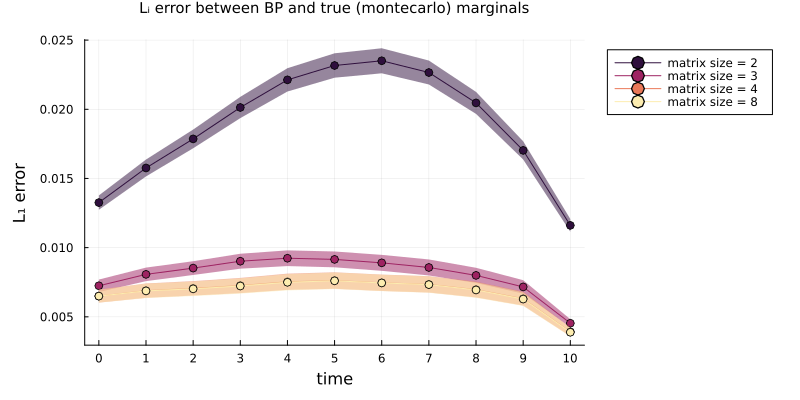

In [13]:
println("SIS with: P(S→I)=λ=$λ, P(I→S)=ρ=$ρ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=$k. T=$T, $nobs random observations from the prior at final time")
println("Average over ", length(l1s_bp), " random instances.")
using ColorSchemes
cg = cgrad(:matter, length(bonddims), categorical=true) |> reverse
pl = plot(xlabel="time", ylabel="L₁ error", xticks=0:T, legend=:bottomright)
for i in eachindex(bonddims)
    plot!(pl, 0:T, l1s_bp_avg[i], ribbon=l1s_bp_std[i], c=cg[i],
        label="matrix size = $(bonddims[i])", m=:o)
end
plot(pl, title="Lᵢ error between BP and true (montecarlo) marginals", titlefontsize=10, 
    legend=:outertopright, size=(800,400), margin=5Plots.mm)